# Tumors Benign\Malignant Classification

# <h3>Importing libraries</h3>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import numpy as np
import seaborn as sns
import scipy
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc, precision_recall_curve
from sklearn.metrics import make_scorer
from sklearn.metrics import balanced_accuracy_score
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

<h3>Loading the dataset</h3>

In [2]:
path = "cancer.csv"
df = pd.read_csv(path)
df.head()

,Id,Diagnosis,Radius (mean),Texture (mean),Perimeter (mean),Area (mean),Smoothness (mean),Compactness (mean),Concavity (mean),Concave points (mean),...,Radius (worst),Texture (worst),Perimeter (worst),Area (worst),Smoothness (worst),Compactness (worst),Concavity (worst),Concave points (worst),Symmetry (worst),Fractal dimension (worst)
0,8510426,B,13.540,14.36,87.46,566.3,0.09779,0.08129,0.06664,0.047810,...,15.110,19.26,99.70,711.2,0.14400,0.17730,0.23900,0.12880,0.2977,0.07259
1,8510653,B,13.080,15.71,85.63,520.0,0.10750,0.12700,0.04568,0.031100,...,14.500,20.49,96.09,630.5,0.13120,0.27760,0.18900,0.07283,0.3184,0.08183
2,8510824,B,9.504,12.44,60.34,273.9,0.10240,0.06492,0.02956,0.020760,...,10.230,15.66,65.13,314.9,0.13240,0.11480,0.08867,0.06227,0.2450,0.07773
3,854941,B,13.030,18.42,82.61,523.8,0.08983,0.03766,0.02562,0.029230,...,13.300,22.81,84.46,545.9,0.09701,0.04619,0.04833,0.05013,0.1987,0.06169
4,85713702,B,8.196,16.84,51.71,201.9,0.08600,0.05943,0.01588,0.005917,...,8.964,21.96,57.26,242.2,0.12970,0.13570,0.06880,0.02564,0.3105,0.07409


## Basic insights from the dataset

In [3]:
df.shape

(569, 32)

#### Checking for columns names, data types, missing values, duplicates and number of unique classes

In [4]:
def summary(df):
    summary_df = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary_df['Missing:np.nan'] = (df.isnull()).sum()
    summary_df['Missing:None'] = (df == "None").sum()
    summary_df['total'] =  summary_df['Missing:np.nan'] + summary_df['Missing:None']
    summary_df['Percent'] = 100*summary_df['total']/len(df)
    summary_df['Duplicates'] = df.duplicated().sum()
    summary_df['Unique'] = df.nunique().values
    summary_df['Count'] = df.count().values
    return summary_df.sort_values(ascending = False, by = 'Percent')

summary(df).style.background_gradient(cmap='Blues')

,dtypes,Missing:np.nan,Missing:None,total,Percent,Duplicates,Unique,Count
Id,int64,0,0,0,0.000000,0,569,569
Diagnosis,object,0,0,0,0.000000,0,2,569
Symmetry (worst),float64,0,0,0,0.000000,0,500,569
Concave points (worst),float64,0,0,0,0.000000,0,492,569
Concavity (worst),float64,0,0,0,0.000000,0,539,569
Compactness (worst),float64,0,0,0,0.000000,0,529,569
Smoothness (worst),float64,0,0,0,0.000000,0,411,569
Area (worst),float64,0,0,0,0.000000,0,544,569
Perimeter (worst),float64,0,0,0,0.000000,0,514,569
Texture (worst),float64,0,0,0,0.000000,0,511,569


In [5]:
df.drop(["Id"], axis = 1, inplace = True)

# Exploratory Data Analysis

## Summary Statistics

In [6]:
df.describe().style.background_gradient(cmap='Blues')

,Radius (mean),Texture (mean),Perimeter (mean),Area (mean),Smoothness (mean),Compactness (mean),Concavity (mean),Concave points (mean),Symmetry (mean),Fractal dimension (mean),Radius (se),Texture (se),Perimeter (se),Area (se),Smoothness (se),Compactness (se),Concavity (se),Concave points (se),Symmetry (se),Fractal dimension (se),Radius (worst),Texture (worst),Perimeter (worst),Area (worst),Smoothness (worst),Compactness (worst),Concavity (worst),Concave points (worst),Symmetry (worst),Fractal dimension (worst)
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


# Distribution of the target variable

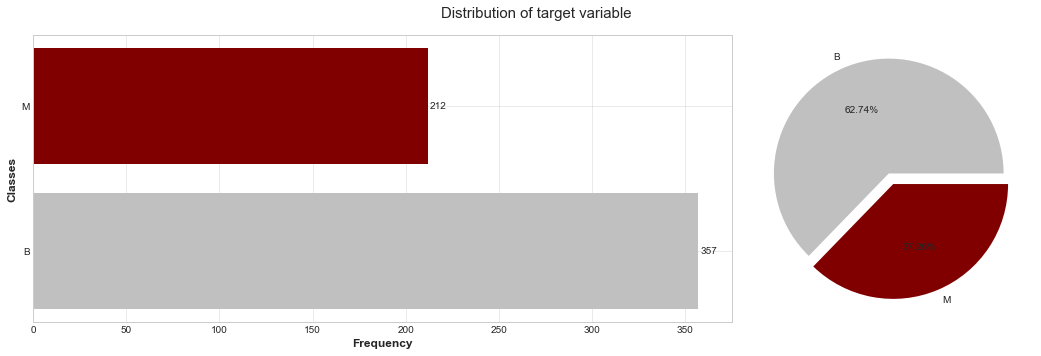

In [7]:
y = df['Diagnosis'].value_counts()
colors = ["Silver","maroon" ]
figure, axes = plt.subplots(1,2, figsize=(15,5), gridspec_kw={'width_ratios':[2,1]})


axes[0].barh(y=y.index, width=y.values, color=colors)
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('Classes')
axes[0].grid(alpha=0.5)
for index, values in enumerate(y):
    axes[0].text(values+1, index, str(values), va='center')

axes[1].pie(y.values, labels=y.index, autopct='%.2f%%', explode=([0.05]*len(y.index)), colors=colors)

    

figure.suptitle('Distribution of target variable', fontsize=15)
plt.tight_layout(pad=1)
plt.show()


# Distribution of the numerical variables

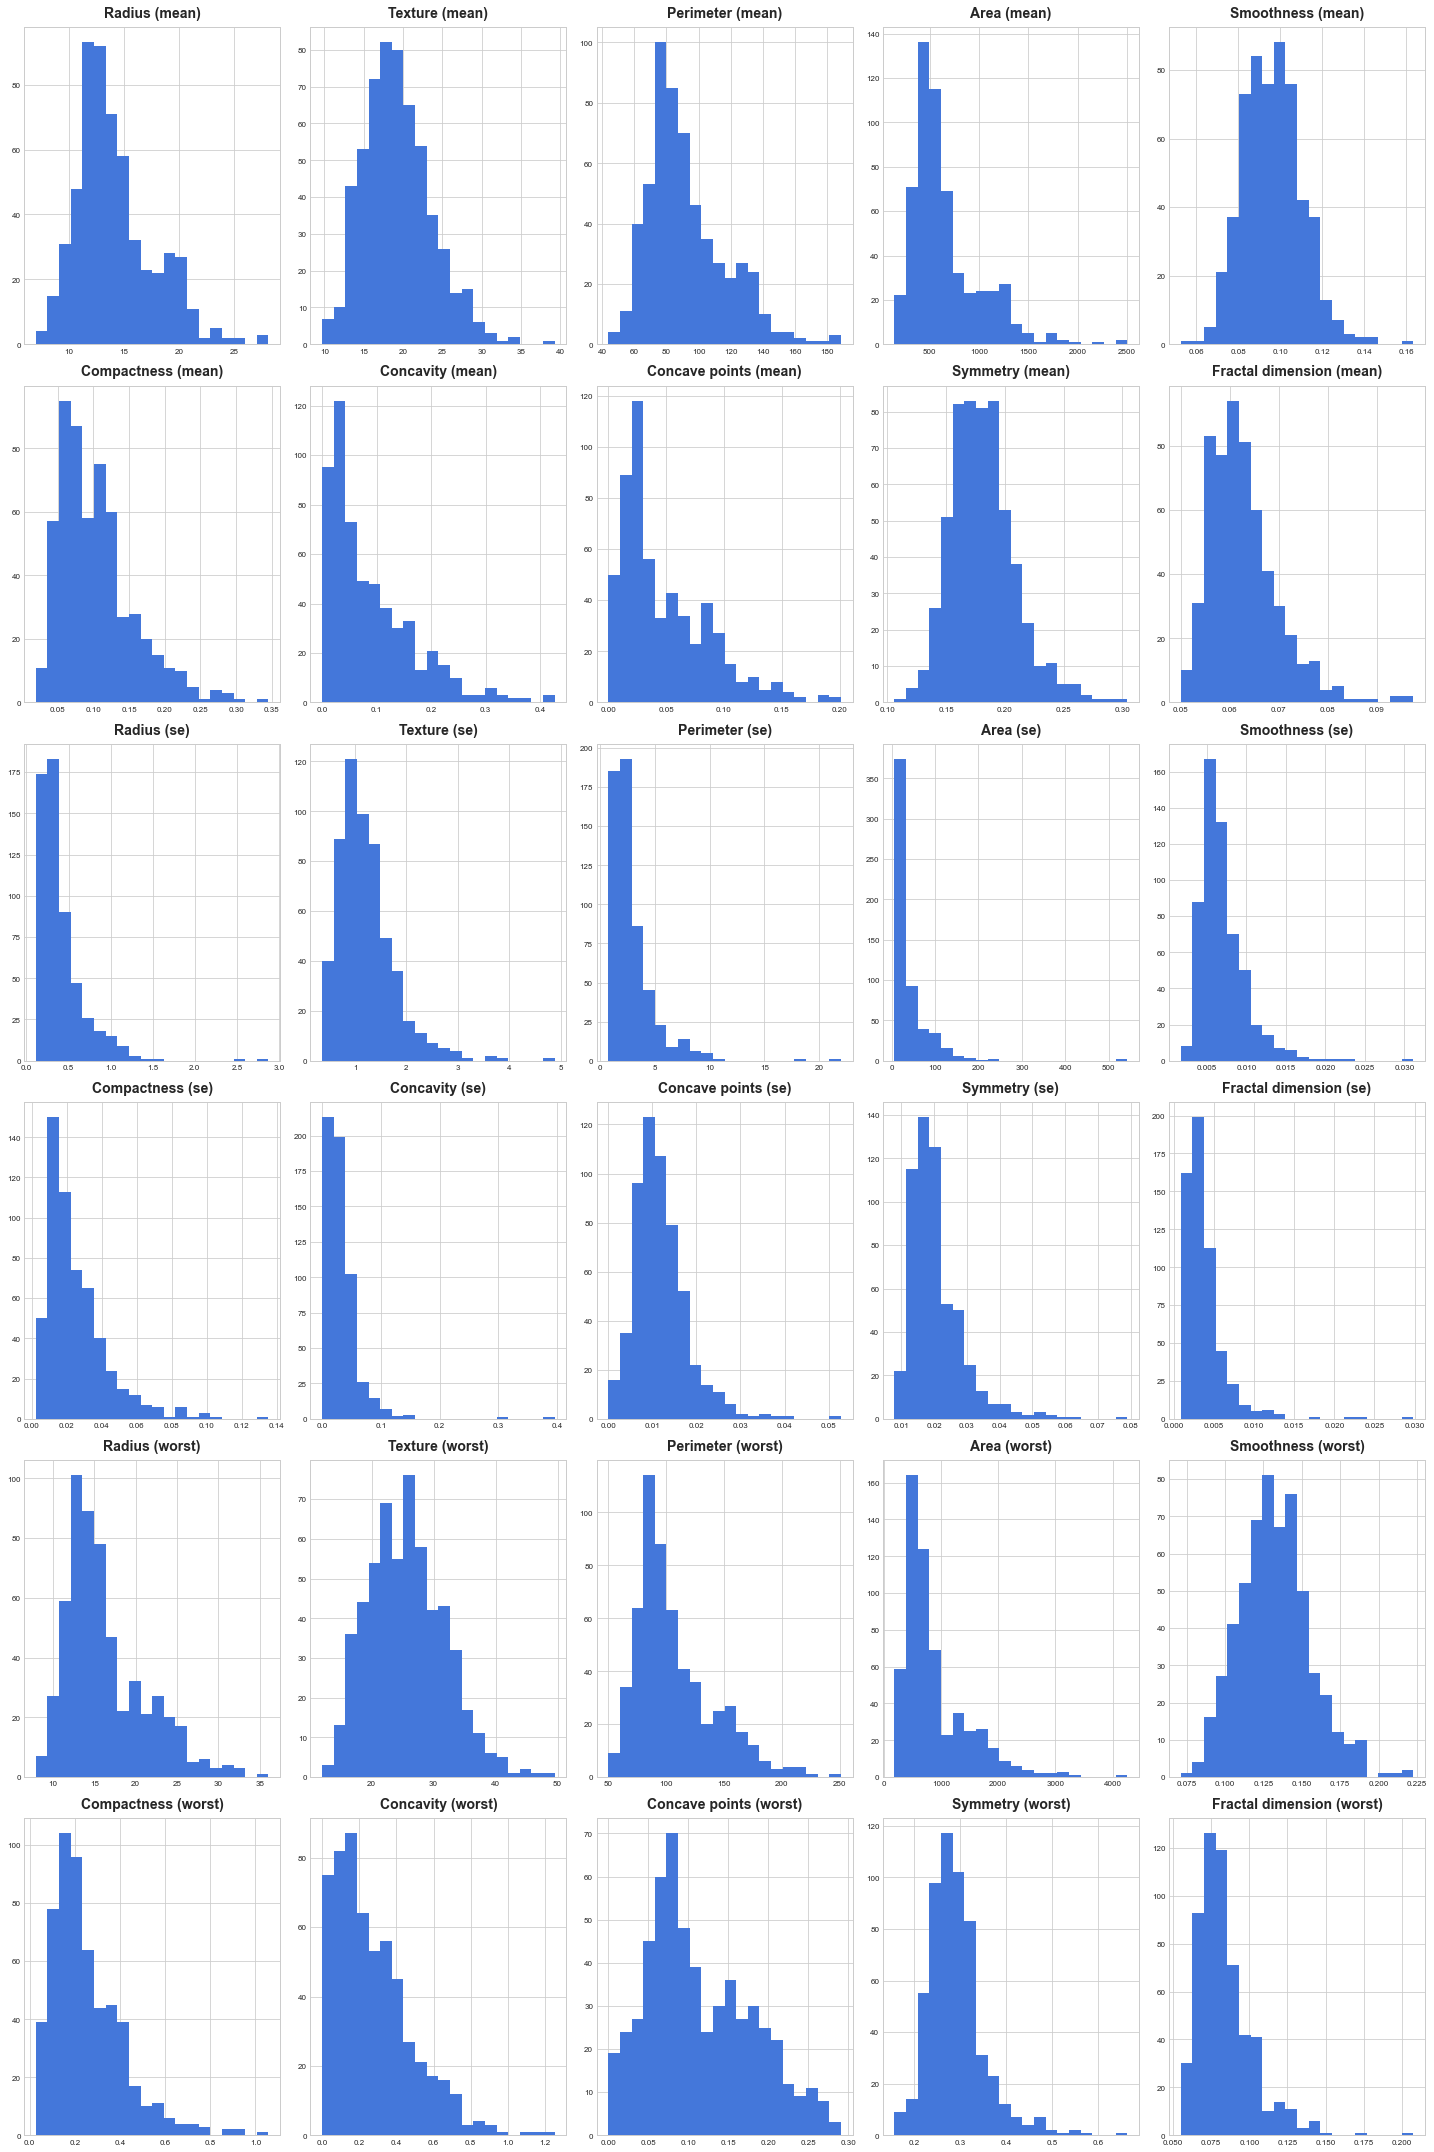

In [8]:
df.hist(figsize=(20, 30), bins=20, xlabelsize=8, ylabelsize=8,color = "#4477DA");

## Coreelation

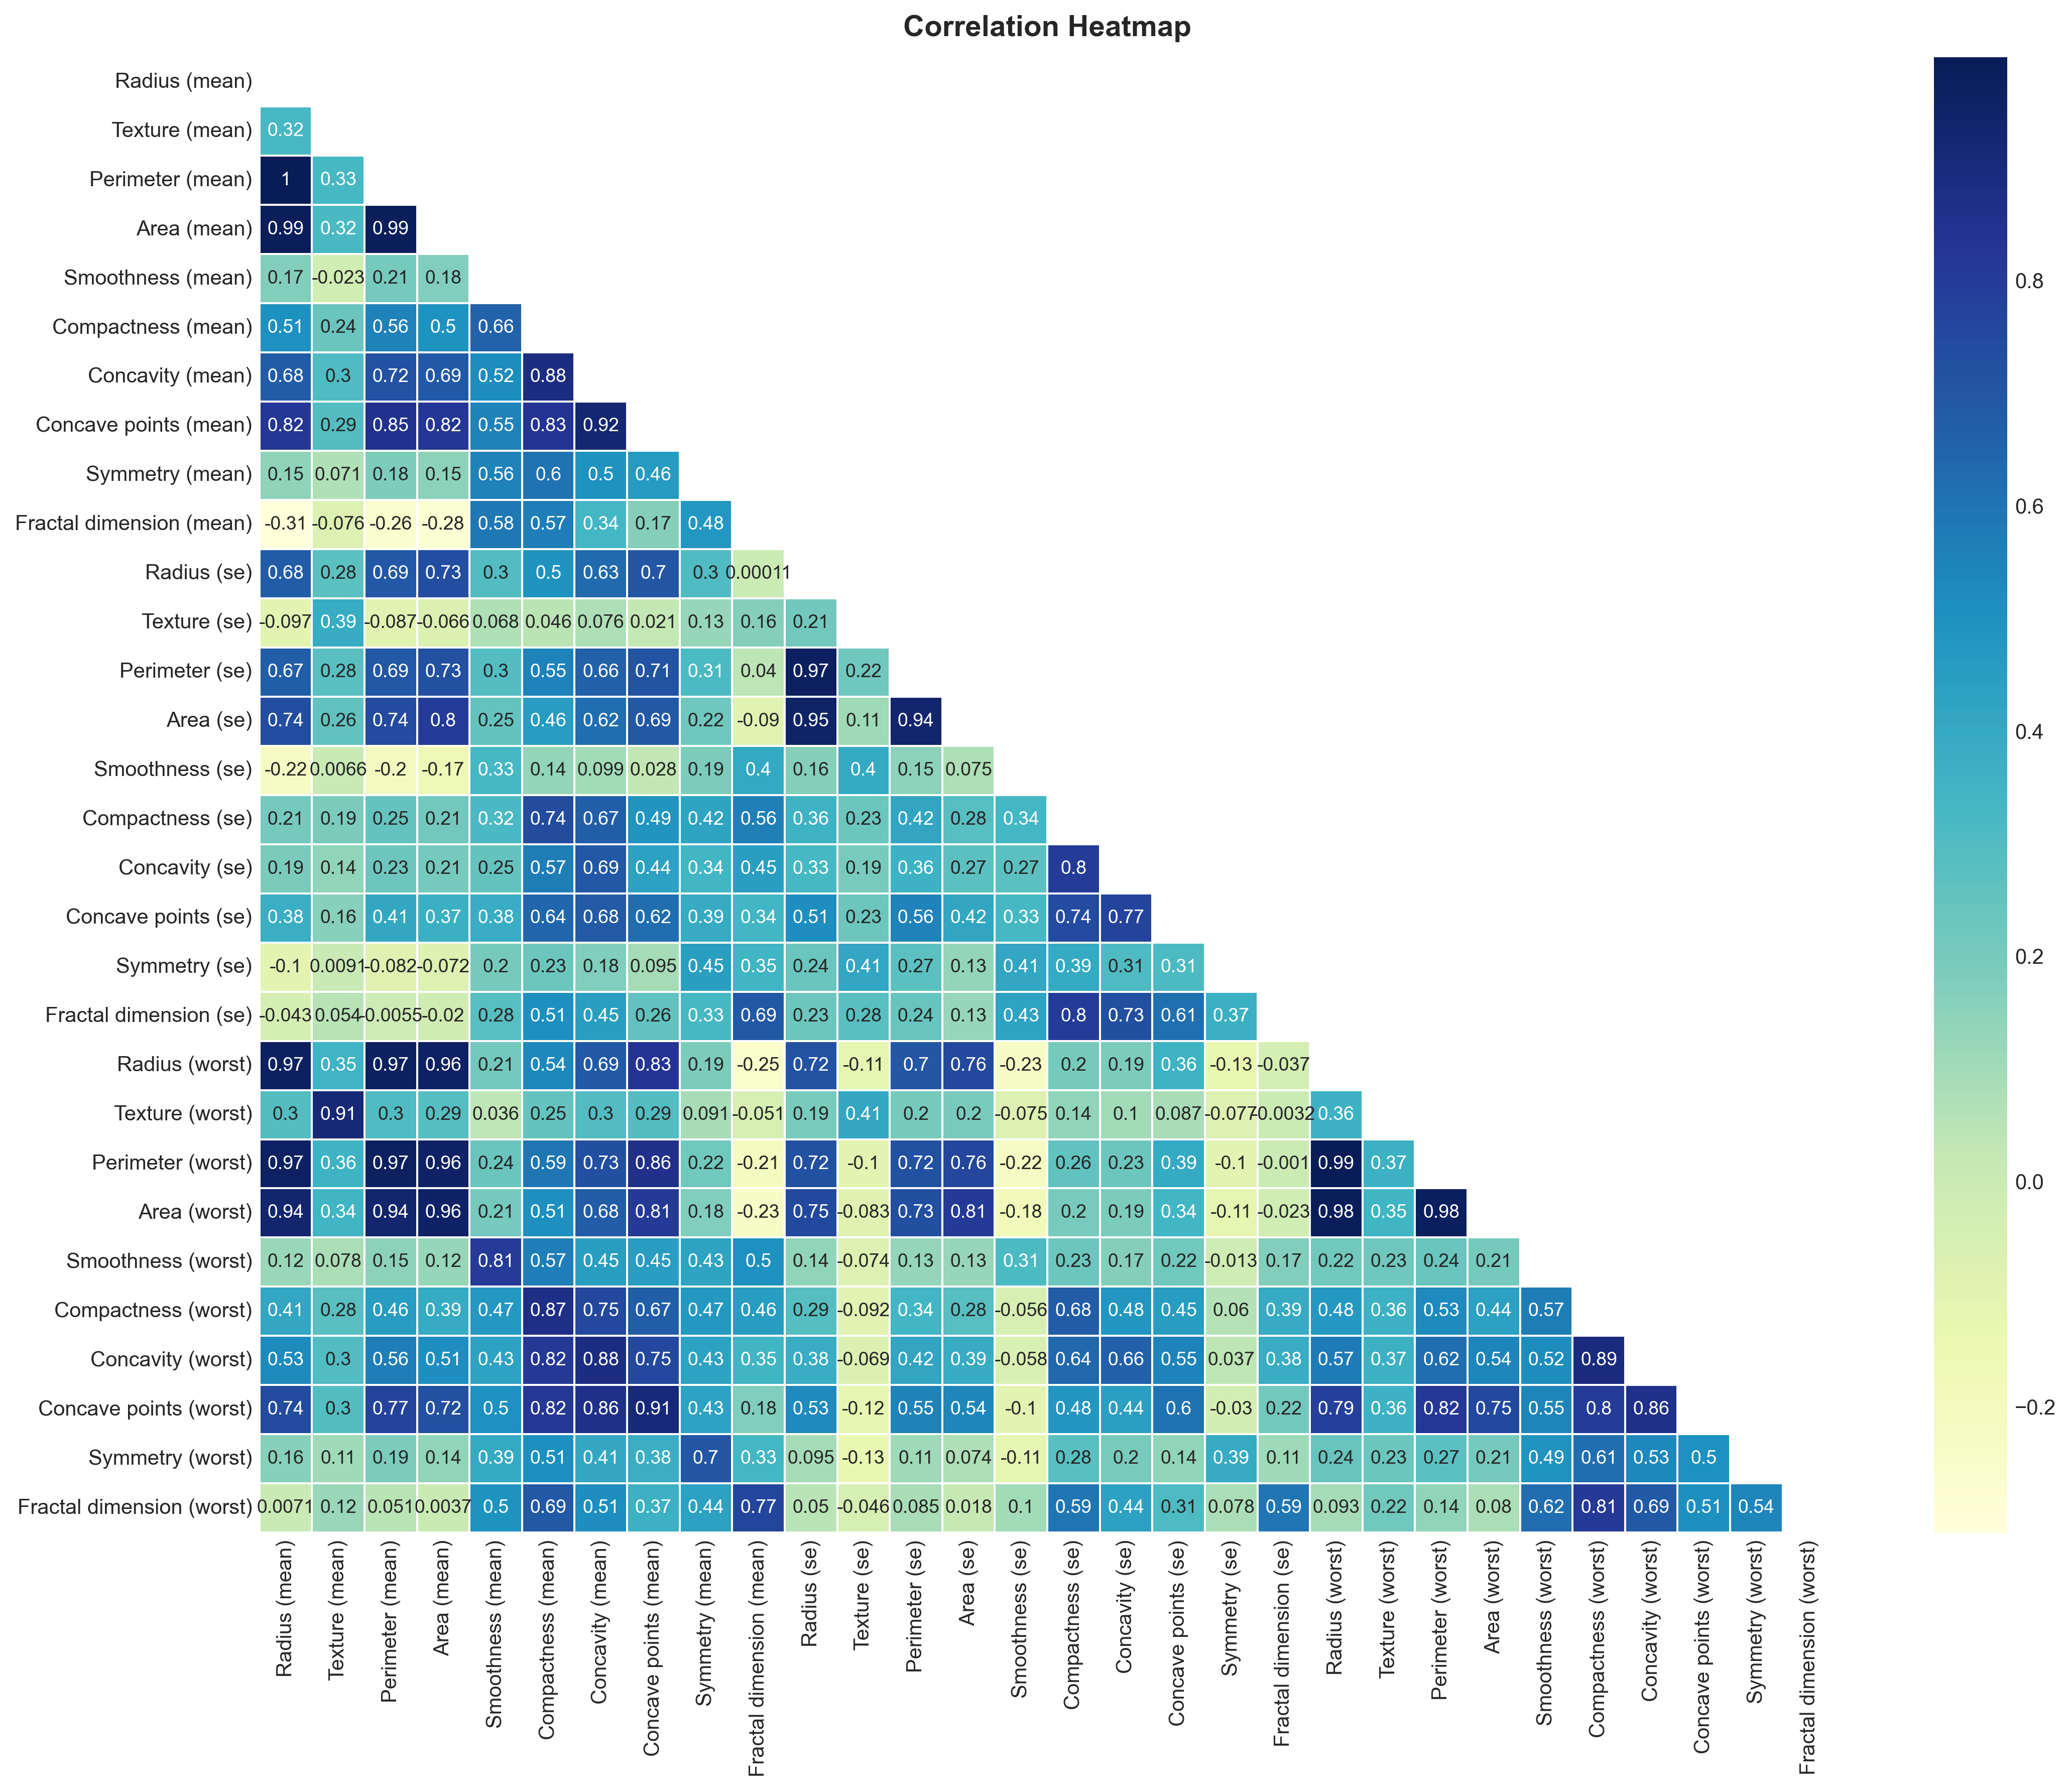

In [9]:
# Plot correlation heatmap
plt.figure(figsize=(15, 12), dpi=300)
corr_matrix = df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, mask=mask, cmap='YlGnBu', linewidth=.5, annot_kws={'size': 9})
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

## Data Preprocessing

### Train-Test split

In [10]:
from sklearn.model_selection import train_test_split

X = df.copy()
y = X.pop("Diagnosis")


x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1,shuffle =True)

print("number of test samples :", x_test.shape[0])
print("number of training samples:",x_train.shape[0])

number of test samples : 171
number of training samples: 398


In [11]:
## Encoding the Target
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

## Features Importance (Mutual information Score)

In [12]:
discrete_features = x_train.dtypes == int  # All discrete features should now have integer dtypes 

from sklearn.feature_selection import mutual_info_classif
def make_mi_scores(x_train,y_train,discrete_features):
    mi_scores = mutual_info_classif(x_train,y_train,discrete_features =discrete_features )
    mi_scores = pd.Series(mi_scores, name = "MI Scores", index = x_train.columns)
    mi_scores = mi_scores.sort_values(ascending = False)
    return mi_scores
mi_scores =  make_mi_scores(x_train,y_train,discrete_features) 
mi_scores

Perimeter (worst)            0.459296
Radius (worst)               0.441922
Area (worst)                 0.440620
Concave points (mean)        0.412463
Concave points (worst)       0.411263
Perimeter (mean)             0.389860
Concavity (mean)             0.357200
Area (mean)                  0.337580
Area (se)                    0.333920
Radius (mean)                0.313211
Concavity (worst)            0.306745
Radius (se)                  0.238172
Perimeter (se)               0.233970
Compactness (worst)          0.218074
Compactness (mean)           0.188598
Texture (worst)              0.123777
Concavity (se)               0.123658
Smoothness (worst)           0.108899
Texture (mean)               0.108439
Fractal dimension (worst)    0.095508
Symmetry (worst)             0.089755
Concave points (se)          0.087638
Symmetry (se)                0.061653
Symmetry (mean)              0.052823
Smoothness (mean)            0.052439
Fractal dimension (mean)     0.037726
Texture (se)

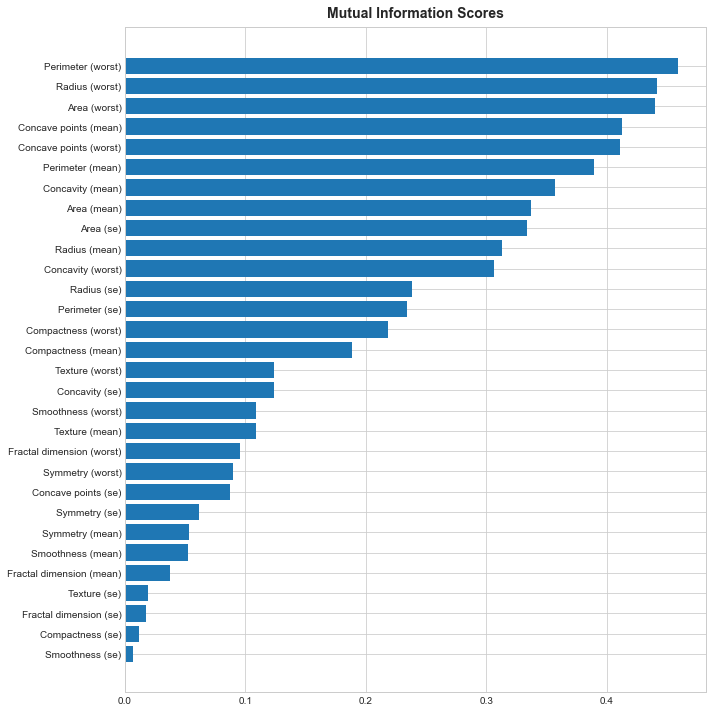

In [13]:
def plot_mi_scores(scores):
    fig, ax = plt.subplots(figsize=(10,10))
    scores = scores.sort_values(ascending = True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    
    
plot_mi_scores(mi_scores)

## Features Scaling

In [14]:
# X_train Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(df_scaled, columns = x_train.columns)
# x_test Scaling
df_scaled = scaler.transform(x_test)
x_test = pd.DataFrame(df_scaled, columns = x_test.columns)
x_test.describe().round(3).T

,count,mean,std,min,25%,50%,75%,max
Radius (mean),171.0,0.077,1.003,-1.662,-0.651,-0.152,0.614,3.175
Texture (mean),171.0,-0.103,0.901,-1.969,-0.810,-0.148,0.477,2.384
Perimeter (mean),171.0,0.084,1.010,-1.638,-0.651,-0.161,0.731,3.310
Area (mean),171.0,0.066,0.977,-1.259,-0.626,-0.245,0.466,3.473
Smoothness (mean),171.0,0.082,0.968,-1.865,-0.622,0.118,0.616,4.750
Compactness (mean),171.0,0.113,1.028,-1.365,-0.659,-0.095,0.648,3.993
Concavity (mean),171.0,0.136,1.090,-1.106,-0.693,-0.255,0.775,4.401
Concave points (mean),171.0,0.126,1.062,-1.249,-0.726,-0.271,0.924,3.604
Symmetry (mean),171.0,0.079,0.917,-1.891,-0.545,-0.039,0.522,3.110
Fractal dimension (mean),171.0,0.061,1.034,-1.737,-0.589,-0.120,0.455,4.736


## Modelling

### Helper functions

#### Ploting Confusion Matrix and Classification Report

In [15]:
from sklearn import metrics
def clf_plot(y_pred) :

    cm = metrics.confusion_matrix(y_test, y_pred,normalize='true')
    cr = pd.DataFrame(metrics.classification_report(y_test, y_pred, digits=3, output_dict=True)).T
    cr.drop(columns='support', inplace=True)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Left: Confusion Matrix
    ax[0] = sns.heatmap(cm, annot=True, fmt='', cmap='YlGnBu', ax=ax[0])
    ax[0].set_xlabel('Predicted labels', fontsize=18)
    ax[0].set_ylabel('True labels', fontsize=18)
    ax[0].set_title('Confusion Matrix', fontsize=20)
    ax[0].xaxis.set_ticklabels(['No', 'Yes'])
    ax[0].yaxis.set_ticklabels(['No', 'Yes'])

    # Right: Classification Report
    ax[1] = sns.heatmap(cr, cmap='YlGnBu', annot=True, linecolor='white', linewidths=0.5, ax=ax[1])
    ax[1].xaxis.tick_top()
    ax[1].set_title('Classification Report', fontsize=20)
    plt.show()

#### Plotting ROC curve

In [17]:
from sklearn.metrics import roc_curve, auc

def roc(model,y_pred):
    # Predict the probabilities of the positive class
    y_pred = model.predict_proba(x_test)[:,1]
    y_pred.shape

    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    # Calculate the AUC score
    auc_score = auc(fpr, tpr)
    x1=np.linspace(0,1,100)
    # Plot the ROC curve
    fig, axes = plt.subplots(1, 1, figsize=(5, 5), dpi=100)
    plt.plot(fpr, tpr, label="ROC curve (AUC = %0.2f)" % auc_score)
    plt.plot(x1,x1,label='baseline')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curve for binary classification")
    plt.legend()
    plt.show()

## Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
# Dictionary to define parameters to test in algorithm
parameters = {
    'C' : [0.001, 0.01, 0.1, 1.0, 10, 100, 1000],
    'class_weight' : ['balanced'],
    'solver' : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}

lr = LogisticRegression()

In [19]:
lr_cv = GridSearchCV(estimator=lr, param_grid=parameters, cv=4).fit(x_train, y_train)
print('Tuned hyperparameters : ', lr_cv.best_params_)
print('accuracy : ', lr_cv.best_score_)

Tuned hyperparameters :  {'C': 0.1, 'class_weight': 'balanced', 'solver': 'lbfgs'}
accuracy :  0.9723737373737373


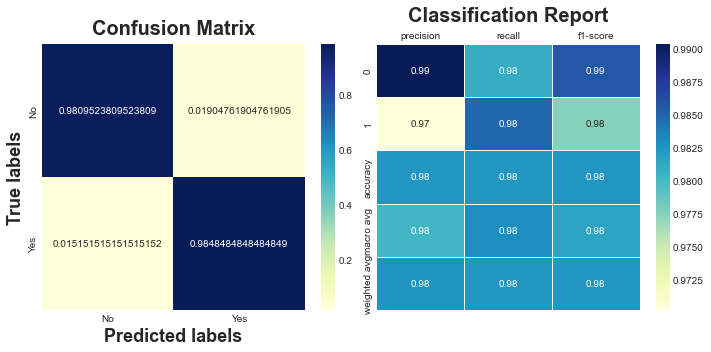

In [20]:
best_model = lr_cv.best_estimator_
yhat_train = best_model.predict(x_train)
yhat_test = best_model.predict(x_test)
clf_plot(yhat_test)

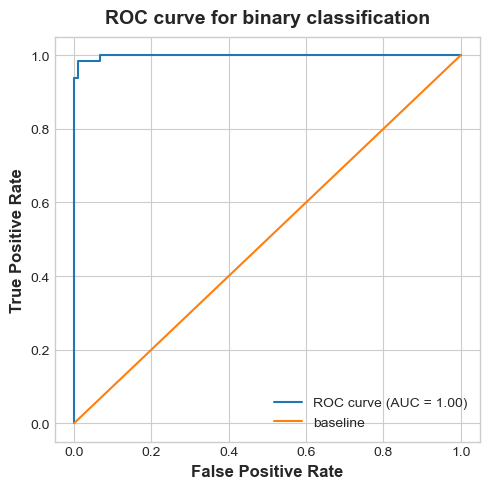

In [21]:
roc(best_model,yhat_test)

## GaussianNB

In [22]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(x_train, y_train)
y_pred=model.predict(x_test)

In [23]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
print("Accuracy: %.3f"%accuracy_score(y_test, y_pred))
print("Precision score: %.3f"%precision_score(y_test,y_pred))
print("Recall score: %.3f"%recall_score(y_test,y_pred))
print("F1 score: %.3f"%f1_score(y_test,y_pred))

Accuracy: 0.930
Precision score: 0.875
Recall score: 0.955
F1 score: 0.913


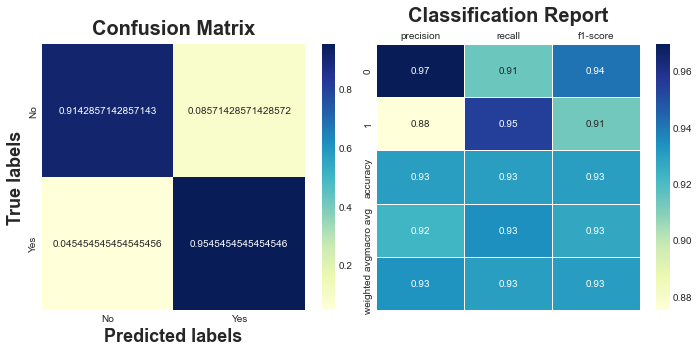

In [24]:
clf_plot(y_pred)

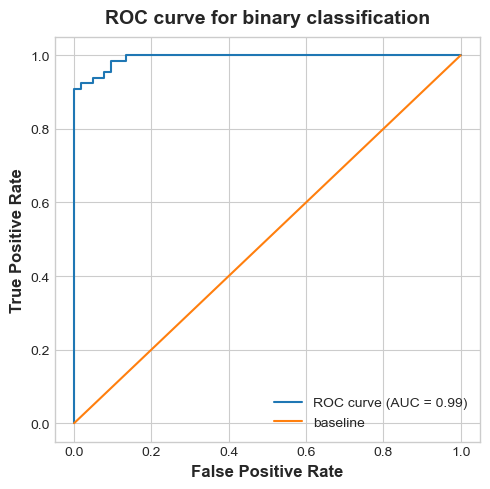

In [25]:
roc(model,y_pred)

## Random Forest Classifier

In [26]:
# RFC
rfc = RandomForestClassifier(max_depth=22, n_estimators=100, random_state=1).fit(x_train, y_train)
yhat_test1 = rfc.predict(x_test)


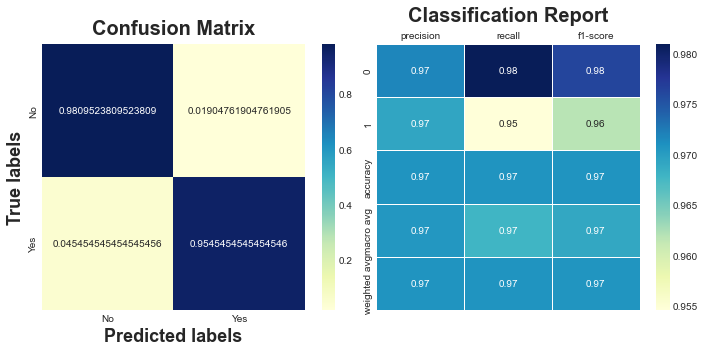

In [27]:
clf_plot(yhat_test1)

## KNeighbors Classifier

In [28]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier().fit(x_train, y_train)
yhat_test2 = knn.predict(x_test)

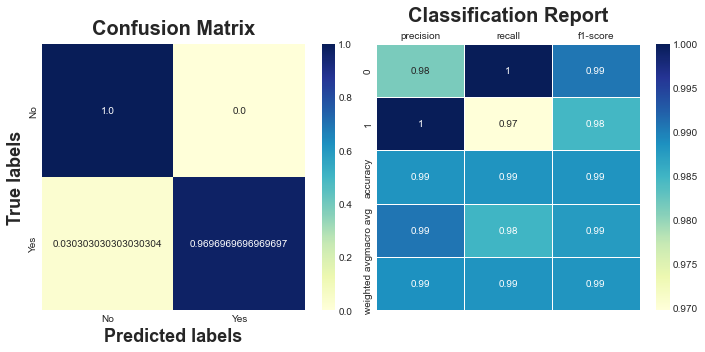

In [29]:
clf_plot(yhat_test2)

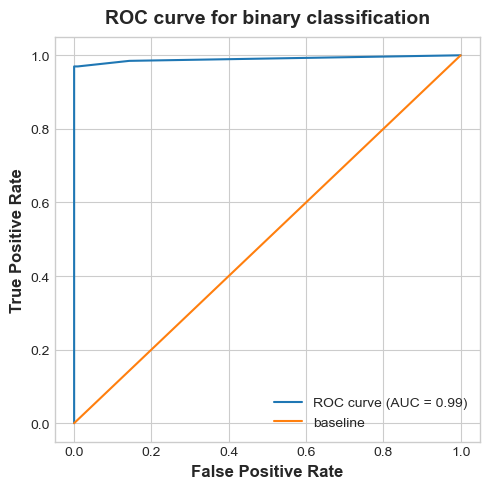

In [30]:
roc(knn,yhat_test2)

## SVC

In [31]:
from sklearn.svm import SVC


svc = SVC(class_weight='balanced')
svc.fit(x_train, y_train)
y_val_pred = svc.predict(x_test)

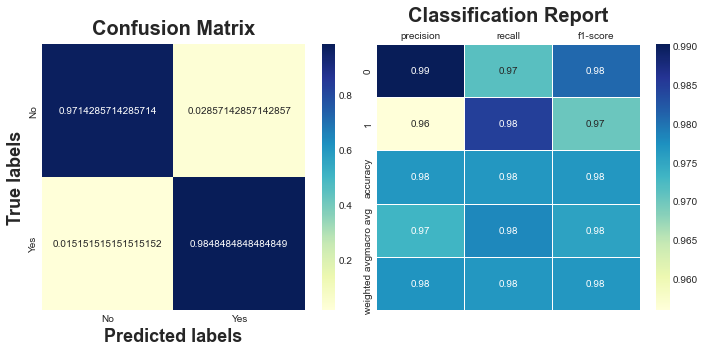

In [32]:
clf_plot(y_val_pred)

## Decision Tree Classifier

In [33]:
from sklearn.tree import DecisionTreeClassifier

# create a Decision Tree Classifier
tree = DecisionTreeClassifier(random_state=122)
tree.fit(x_train, y_train)
y_val_pred2 = tree.predict(x_test)

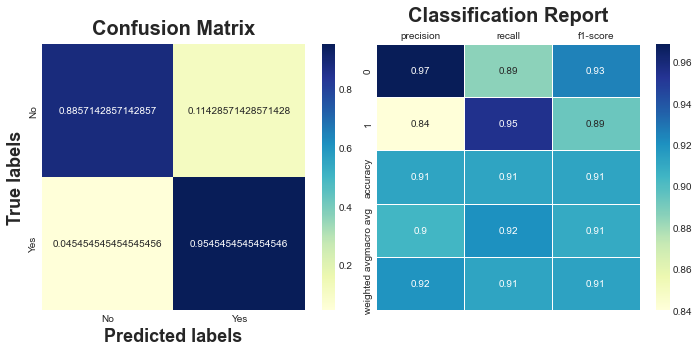

In [34]:
clf_plot(y_val_pred2)

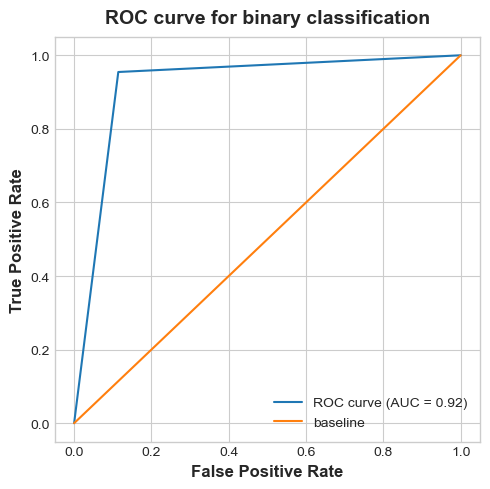

In [35]:
roc(tree,y_val_pred2)

## Conclusion

### Comparing models performance

In [36]:
def measure_error(y_test, y_pred, label):
    return pd.Series({"Accuracy": accuracy_score(y_test, y_pred),
                     "Precision": precision_score(y_test, y_pred),
                     "Recall": recall_score(y_test, y_pred),
                     "F1": f1_score(y_test, y_pred),
                     "AUROC": roc_auc_score(y_test, y_pred)}, 
                     name = label)

In [37]:
Log_reg = pd.concat([measure_error(y_test, yhat_test,"Log_reg")],axis = 1)
GaussianNB = pd.concat([measure_error(y_test, y_pred,"GaussianNB")],axis = 1)
RFC = pd.concat([measure_error(y_test, yhat_test1,"RFC")],axis = 1)
KNN = pd.concat([measure_error(y_test, yhat_test2,"KNN")],axis = 1)
SVC = pd.concat([measure_error(y_test, y_val_pred,"SVC")],axis = 1)
DT = pd.concat([measure_error(y_test, y_val_pred2,"DT")],axis = 1)

In [38]:
compare_models =  pd.concat([Log_reg,GaussianNB,RFC,KNN,SVC,DT],axis =1)
compare_models.style.background_gradient(cmap='Blues')

,Log_reg,GaussianNB,RFC,KNN,SVC,DT
Accuracy,0.982456,0.929825,0.970760,0.988304,0.976608,0.912281
Precision,0.970149,0.875000,0.969231,1.000000,0.955882,0.840000
Recall,0.984848,0.954545,0.954545,0.969697,0.984848,0.954545
F1,0.977444,0.913043,0.961832,0.984615,0.970149,0.893617
AUROC,0.982900,0.934416,0.967749,0.984848,0.978139,0.920130


## Result :

### Based on the above output, best algorithm base on F1 Score is : KNN

---
# END
Thank you :)